In [1]:
%matplotlib notebook
import numpy as np
import time
import ipywidgets as widgets
import matplotlib.pyplot as plt

In [2]:
import os
import gc
import sys
srcpath = os.path.realpath('./../SourceFiles')
sys.path.append(srcpath)
#from teproteus import TEProteusAdmin, TEProteusInst
from tevisainst import TEVisaInst
from teproteus import TEProteusAdmin as TepAdmin
from teproteus import TEProteusInst as TepInst
from pulse_sequence import EPR_pulse

# Connect to the instrument

In [3]:
# Connect to instrument

# Please choose appropriate address:
inst_addr = '169.254.18.140' #Proteus Lan

inst = TEVisaInst(inst_addr)

resp = inst.send_scpi_query("*IDN?")
print('connected to: ' + resp)



connected to: Tabor Electronics,P2582D,000002248484,1.237.0 --slot#: 5, 


# connect to instrument and initialize

In [4]:
# The paranoia-level is either 
# low (0), normal (1) or debug (2)
paranoia_level = 2

print ('Reset instrument ..')

# Reset the instrument
inst.send_scpi_cmd('*CLS; *RST')

dac_mode = 16 

# Get the model:
model_name = inst.send_scpi_query('SYST:INF:MODel?')
print('Model: {0} '.format(model_name))

# Get model dependant parameters:

# scaling
max_dac = 2 ** dac_mode - 1
half_dac = max_dac / 2.0
wpt_type = np.uint16   

    
# Get the available memory in bytes of wavform-data (per DDR):
resp = inst.send_scpi_query(":TRACe:FREE?")
arbmem_capacity = int(resp)
print("Available memory per DDR: {0:,} wave-bytes".format(arbmem_capacity))

sampleRateDAC = 2.5E9
cmd = ':FREQ:RAST {0}'.format(sampleRateDAC) 
inst.send_scpi_cmd(cmd)

print('Done')

Reset instrument ..
Model: P2582D 
Available memory per DDR: 4,286,532,544 wave-bytes
Done


# Generate segments with waveform and markers-data for measuring T2 with Phase cycling

In [5]:
def generate_T2_segments(pulse_gen, base_pulse1, base_pulse2,
                                     fixed_delay=2e-9, dt_list=None, phase_list=None):
    """
    Generate one (t, y) segment per (dt, phase_combo) pair.
    
    Parameters:
        pulse_gen: EPR_pulse instance
        base_pulse1, base_pulse2: tuples like ('Gaussian', duration, param_dict) and ('Square', ...)
        fixed_delay: base delay in seconds (before adding dt)
        dt_list: list or array of dt increments (seconds)
        phase_list: list of [phase1, phase2] values

    Returns:
        segments: list of ((dt, phase_combo), (t, y))
    """
    segments = []

    for dt in dt_list:
        total_delay = fixed_delay + dt
        delay_step = ('delay', total_delay, {'points': int(round(total_delay * pulse_gen.sampling_rate))})

        for phase in phase_list:
            # Inject phase into pulses
            p1 = (base_pulse1[0], base_pulse1[1], {**base_pulse1[2], 'phase': phase[0]})
            p2 = (base_pulse2[0], base_pulse2[1], {**base_pulse2[2], 'phase': phase[1]})

            steps = [p1, delay_step, p2, delay_step]
            t, y = pulse_gen.pulse_sequence(steps)
            mrk = pulse_gen.marker(steps)
            segments.append(((dt, phase), (t, y, mrk)))

    return segments
pulse = EPR_pulse(sampling_rate=2.5e9, Vpp=500)

# Define pulses
P1 = ('Gaussian', 450e-9, {'amplitude': 1, 'f_c': 0e5})
P2 = ('Square',   900e-9, {'amplitude': 1, 'f_c': 00e5})

# Phase combos
phase_combos = [
    [0, 0],
    [180, 180],
]

# List of dt values
dt_list = np.arange(300e-9, 2000e-9, 1000e-9)  # from 0 ns to 20 ns in 2 ns steps

# Generate all segments
segments = generate_T2_segments(pulse, P1, P2, fixed_delay=2e-9,
                                            dt_list=dt_list, phase_list=phase_combos)

print(f"Generated {len(segments)} segments: {len(dt_list)} dt × {len(phase_combos)} phases")

Generated 4 segments: 2 dt × 2 phases


Plot out some segments to double check 

500
500
65535
500
32768
500
500
65535
500
32768


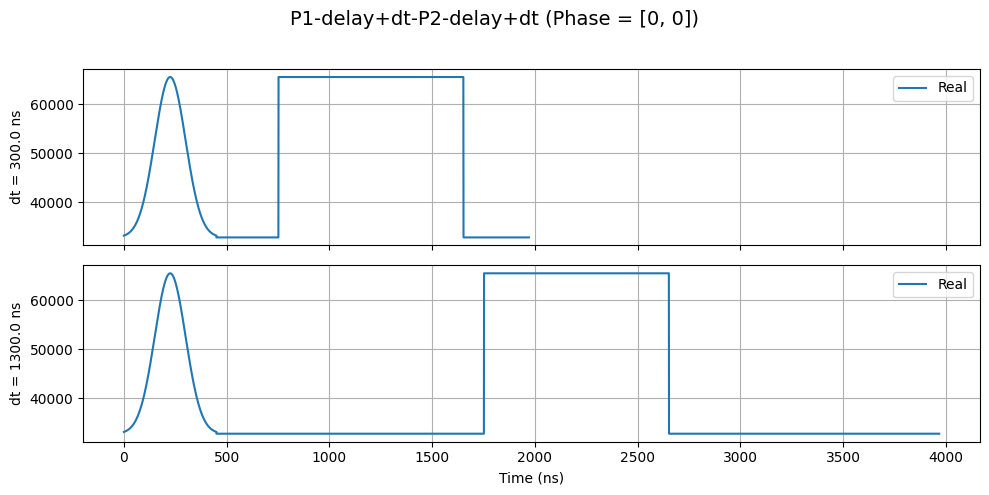

In [6]:
%matplotlib inline
dt_list_sample = dt_list[::]  # Sample every 10th dt for plotting
fig, axs = plt.subplots(len(dt_list_sample), 1, figsize=(10, 2.5 * len(dt_list_sample)), sharex=True)
for i, dt in enumerate(dt_list_sample):
    (t, y, m) = next((v for (k, v) in segments if k[0] == dt and k[1] == [0, 0]))
    axs[i].plot(t * 1e9, pulse.DAC_output(np.real(y)), label='Real')
    axs[i].set_ylabel(f'dt = {dt*1e9:.1f} ns')
    axs[i].legend()
    axs[i].grid(True)
    print(max(pulse.DAC_output(np.real(y))))
    print(min(pulse.DAC_output(np.real(y))))

    #print (np.max())
axs[-1].set_xlabel('Time (ns)')
plt.suptitle('P1-delay+dt-P2-delay+dt (Phase = [0, 0])', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Load the T2 sequences into the AWT

In [7]:
waves = []
for i, ((dt, phase), (t, y, m)) in enumerate(segments):
    ichan = 0
    ch = 1 # Output channel
    segnum = i+1
    wav = pulse.DAC_output(np.real(y))
    waves.append(wav)
    mrk = m *17
    mrk = mrk.astype(np.int8)
    seglen = len(wav)


    # resp = inst.send_scpi_query(':SYST:ERR?')
    # resp = resp.rstrip()
    # if not resp.startswith('0'):
    #     print('ERROR: "{0}" before writing binary values'.format(resp))

    # Select channel
    cmd = ':INST:CHAN {0}'.format(ch)
    inst.send_scpi_cmd(cmd)

    # Define segment
    cmd = ':TRAC:DEF {0}, {1}'.format(segnum, seglen)
    inst.send_scpi_cmd(cmd)

    # Select the segment
    cmd = ':TRAC:SEL {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)

    # resp = inst.send_scpi_query(':SYST:ERR?')
    # resp = resp.rstrip()
    # if not resp.startswith('0'):
    #     print('ERROR: "{0}" before writing binary values'.format(resp))

    # increase the timeout before sending binary data
    inst.timeout = 3000

    # Send the binary-data:
    inst.write_binary_data('*OPC?; :TRAC:DATA', wav)
    # set normal timeout
    inst.timeout = 1000

    # Read if there is an error
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    print('Downloaded waveform to segment {0} of channel {1}'.format(segnum, ch))
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" before writing binary values'.format(resp))

    # load markers
    markerNum = 1
    inst.timeout = 30000
    inst.write_binary_data('*OPC?; :MARK:DATA', mrk)
    inst.timeout = 10000
    #Read if there is an error
    resp = inst.send_scpi_query(':SYST:ERR?')
    resp = resp.rstrip()
    if not resp.startswith('0'):
        print('ERROR: "{0}" after writing binary values'.format(resp))

    
    # Select the marker to assign to above trace
    cmd = ':MARK:SEL {0}'.format(markerNum)
    inst.send_scpi_cmd(cmd)

    cmd = ':MARK:STAT ON'
    inst.send_scpi_cmd(cmd)

    
    resp = inst.send_scpi_query(':SYST:ERR?')
    print("Marker Error = ")
    print(resp)
    print('Downloaded marker to segment {0} of channel {1}'.format(segnum, ch))


    cmd = ':FUNC:MODE:SEGM {0}'.format(segnum)
    inst.send_scpi_cmd(cmd)

    # I dont understand these comments 
    #cmd = ':VOLT MAX'
    #rc = inst.send_scpi_cmd(cmd)

    #cmd = ':VOLT:OFFS 0'
    #rc = inst.send_scpi_cmd(cmd)

    cmd = ':OUTP ON'
    rc = inst.send_scpi_cmd(cmd)

    resp = inst.send_scpi_query(':SYST:ERR?')

    print("End of CH1, Gen Error = ")

    print(resp)

resp = inst.send_scpi_query(':SYST:ERR?')
print (resp)
print ("downloaded {} segments".format(len(segments)))

500
Downloaded waveform to segment 1 of channel 1
Marker Error = 
0, no error
Downloaded marker to segment 1 of channel 1
End of CH1, Gen Error = 
0, no error
500
Downloaded waveform to segment 2 of channel 1
Marker Error = 
0, no error
Downloaded marker to segment 2 of channel 1
End of CH1, Gen Error = 
0, no error
500
Downloaded waveform to segment 3 of channel 1
Marker Error = 
0, no error
Downloaded marker to segment 3 of channel 1
End of CH1, Gen Error = 
0, no error
500
Downloaded waveform to segment 4 of channel 1
Marker Error = 
0, no error
Downloaded marker to segment 4 of channel 1
End of CH1, Gen Error = 
0, no error
0, no error
downloaded 4 segments


int8
<class 'numpy.ndarray'>
[32403 32398 32392 ... 32768 32768 32768]


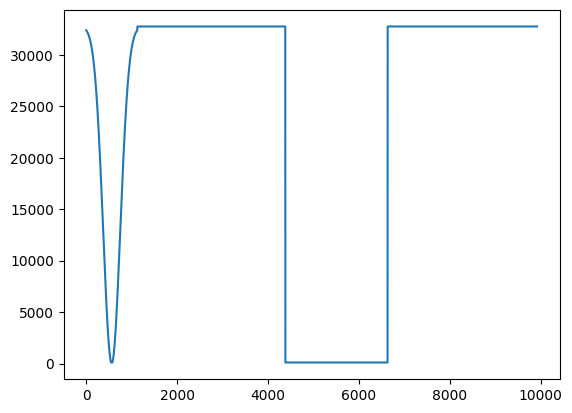

In [8]:
print(mrk.dtype)
print(type (mrk))
print((wav))
plt.plot(wav)

In [9]:
# Load task table 
tasklen = len(segments)

channb= 1 
#Select channel
cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd(cmd)

# set task table length 
cmd = ':TASK:COMP:LENG {0}'.format(tasklen)
inst.send_scpi_cmd(cmd)

for jj in range(tasklen):
    curr_task = jj+1
    loop = jj+1
    segnb = jj+1
    cmd = ':TASK:COMP:SEL {0}'.format(curr_task)
    inst.send_scpi_cmd(cmd)
    
    cmd = ':TASK:COMP:TYPE SING'
    inst.send_scpi_cmd(cmd)
    
    
    # cmd = ':TASK:COMP:LOOP {0}'.format(loop)
    # inst.send_scpi_cmd(cmd)
    if curr_task==1:
        cmd = ':TASK:COMP:DTR ON'
        inst.send_scpi_cmd(cmd)

    cmd = ':TASK:COMP:SEGM {0}'.format(segnb)
    inst.send_scpi_cmd(cmd)
    
    if curr_task==tasklen:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(1)
        inst.send_scpi_cmd(cmd)
    else:
        cmd = ':TASK:COMP:NEXT1 {0}'.format(curr_task+1)
        inst.send_scpi_cmd(cmd)

cmd = ':TASK:COMP:WRIT'
inst.send_scpi_cmd(cmd)
print('Downloading Task table of channel {0}'.format(channb))

resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

 

0, no error


In [10]:
# Switch to the task mode and turn on channel and markers outputs
channb=1

cmd = ':INST:CHAN {0}'.format(channb)
inst.send_scpi_cmd(cmd)

cmd = ':OUTP ON'
inst.send_scpi_cmd(cmd)

cmd = 'FUNC:MODE TASK'
inst.send_scpi_cmd(cmd)

        
for jj in range(4):

    m = jj+1

    cmd = ':MARK:SEL {0}'.format(m)
    inst.send_scpi_cmd(cmd)

    cmd = ':MARK ON'
    inst.send_scpi_cmd(cmd) 
    
resp = inst.send_scpi_query(':SYST:ERR?')
print(resp)

0, no error


# Digitizer

Waveform Length 28800
ADC Clk Freq 2500000000.0
Aquisition Length 1.152e-05
Dig Frequency = 
2500000000.000
Dig error = 
0, no error
Set complex error = 
0, no error
Total read size in bytes: 57600



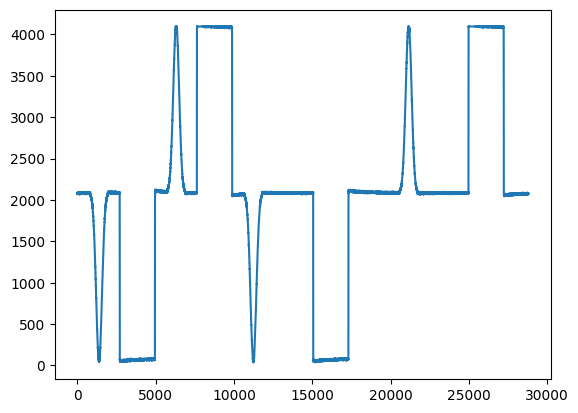

In [11]:

# reserve waveform mem

# Start the digitizer

# initialize DAC and take the first capture.

#Set number of frames to be collected
numframes, framelen = 1, 4800*6# remember multiple of 96
totlen = numframes * framelen

print('Waveform Length {0}'.format(totlen))

wav1 = np.zeros(totlen, dtype=np.uint16)

sampleRateADC = sampleRateDAC

cmd = ':DIG:MODE DUAL'
inst.send_scpi_cmd(cmd)

print('ADC Clk Freq {0}'.format(sampleRateADC))
cmd = ':DIG:FREQ  {0}'.format(sampleRateADC)
inst.send_scpi_cmd(cmd)

print('Aquisition Length {0}'.format(framelen/sampleRateADC))

resp = inst.send_scpi_query(':DIG:FREQ?')
print("Dig Frequency = ")
print(resp)

# Enable capturing data from channel 1
cmd = ':DIG:CHAN:SEL 1'
inst.send_scpi_cmd(cmd)

resp = inst.send_scpi_query(':SYST:ERR?')
print("Dig error = ")
print(resp)
'''
cmd = ':DIG:DDC:CLKS AWG'
rc = inst.send_scpi_cmd(cmd)
'''
resp = inst.send_scpi_query(':SYST:ERR?')
print("Set complex error = ")
print(resp)
 
cmd = ':DIG:CHAN:STATE ENAB'
inst.send_scpi_cmd(cmd)

# trigger from the task list
cmd = ':DIG:TRIG:SOURCE TASK1'
inst.send_scpi_cmd(cmd)

cmd = ':DIG:ACQuire:FRAM:DEF {0},{1}'.format(numframes, framelen)
inst.send_scpi_cmd(cmd)

# Select the frames for the capturing 
capture_first, capture_count = 1, numframes
cmd = ':DIG:ACQuire:FRAM:CAPT {0},{1}'.format(capture_first, capture_count)
inst.send_scpi_cmd(cmd)

'''
% Wait for frame aq to complte
for n = 1:250
    res = inst.SendScpi(':DIG:ACQ:FRAM:STAT?');
    res = convertCharsToStrings(res.RespStr);
    res = strtrim(res);
    items = split(res, ',');
    items = str2double(items);
    if length(items) >= 3 && items(2) == 1
        break
    end
    if mod(n, 10) == 0                
        fprintf('%d. %s Time:\n', fix(n / 10), res);                                
    end
    pause(0.1);
end

'''
################################################################################
# Start the digitizer's capturing machine
cmd = ':DIG:INIT ON'
inst.send_scpi_cmd(cmd)
cmd = ':DIG:TRIG:IMM'
inst.send_scpi_cmd(cmd)
cmd = ':DIG:INIT OFF'
inst.send_scpi_cmd(cmd)
################################################################################

# Choose which frames to read (all in this example)
cmd = ':DIG:DATA:SEL ALL'
inst.send_scpi_cmd(cmd)

# Choose what to read 
# (only the frame-data without the header in this example)
cmd = ':DIG:DATA:TYPE FRAM'
inst.send_scpi_cmd(cmd)

# Get the total data size (in bytes)
resp = inst.send_scpi_query(':DIG:DATA:SIZE?')
num_bytes = np.uint32(resp)
print('Total read size in bytes: ' + resp)
print()

# Read the data that was captured by channel 1:
inst.send_scpi_cmd(':DIG:CHAN:SEL 1')
wavlen = num_bytes // 2
rc = inst.read_binary_data(':DIG:DATA:READ?', wav1, wavlen)

################################################################################
%matplotlib inline
plt.plot(wav1)
plt.show()
